# Multi-Armed Bandit Problem

Adapted from [Thompson sampling](https://github.com/andrecianflone/thompson/blob/master/thompson.ipynb) in Github,              [Multi-Armed Bandits](https://jamesrledoux.com/algorithms/bandit-algorithms-epsilon-ucb-exp-python/) from James LeDoux

In [1]:
#imports and the standard k-armed bandit. The get_reward_regret samples the reward for the given action.

import numpy as np
import matplotlib.pyplot as plt
from pdb import set_trace

stationary=True
class Bandit():
    
  def __init__(self, arm_count):
    """
    Multi-armed bandit with rewards 1 or 0.
    
    # 1 = ad was sucsessful
    # 0 = ad was NOT sucsessful
    """
    self.arm_count = arm_count
    self.generate_thetas()
    self.timestep = 0
    global stationary
    self.stationary=stationary
    
  def generate_thetas(self):
    self.thetas = np.random.uniform(0,1,self.arm_count)
  
  def get_reward_regret(self, arm):
    
    self.timestep += 1
    if (self.stationary==False) and (self.timestep%100 == 0) :
      self.generate_thetas()
    # Simulate bernouilli sampling
    sim = np.random.uniform(0,1,self.arm_count)
    rewards = (sim<self.thetas).astype(int)
    reward = rewards[arm]
    regret = self.thetas.max() - self.thetas[arm]
    
    return reward, regret

###### Random Sampling

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# Implementing Random Selection
class randomChoice():
  
  def __init__(self, bandit):

    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) # action count
    
  def name():
    return 'random'

  def get_action(self):
    theta = self.Q / (self.Q + self.N)
    return theta.argmax()
    
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm])


##### Algorithm: $\epsilon$-greedy

In [3]:
epsilon = 0.1
class EpsilonGreedy():

  def __init__(self, bandit):
    global epsilon
    self.epsilon = epsilon
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) # action count
  
  @staticmethod
  def name():
    return 'epsilon-greedy'
  
  def get_action(self):
    if np.random.uniform(0,1) > self.epsilon:
      action = self.Q.argmax()
    else:
      action = np.random.randint(0, self.arm_count)
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

###### Algorithm: Upper Confidence Bound (UCB)

In [4]:
ucb_c = 2
class UCB():

  def __init__(self, bandit):
    global ucb_c
    self.ucb_c = ucb_c
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) + 0.0001 # action count
    self.timestep = 1
  
  @staticmethod
  def name():
    return 'ucb'
  
  def get_action(self):
    ln_timestep = np.log(np.full(self.arm_count, self.timestep))
    confidence = self.ucb_c * np.sqrt(ln_timestep/self.N)
    action = np.argmax(self.Q + confidence)
    self.timestep += 1
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

##### Algorithm: Thompson($K$,$\alpha$, $\beta$)

In [5]:
class BetaAlgo():
  """
  The algos try to learn which Bandit arm is the best to maximize reward.
  
  It does this by modelling the distribution of the Bandit arms with a Beta, 
  assuming the true probability of success of an arm is Bernouilli distributed.
  """
  def __init__(self, bandit):
    """
    Args:
      bandit: the bandit class the algo is trying to model
    """
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.alpha = np.ones(self.arm_count)
    self.beta = np.ones(self.arm_count)
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.alpha[arm] += reward
    self.beta[arm] += 1 - reward

class BernGreedy(BetaAlgo):
  def __init__(self, bandit):
    super().__init__(bandit)
  
  @staticmethod
  def name():
    return 'beta-greedy'
   
  def get_action(self):
    """ Bernouilli parameters are the expected values of the beta"""
    theta = self.alpha / (self.alpha + self.beta)
    return theta.argmax()
  
class BernThompson(BetaAlgo):
  def __init__(self, bandit):
    super().__init__(bandit)

  @staticmethod
  def name():
    return 'thompson'
  
  def get_action(self):
    """ Bernouilli parameters are sampled from the beta"""
    theta = np.random.beta(self.alpha, self.beta)
    return theta.argmax()


###### Comparing different models in various experiments

In [6]:
def plot_data(y):
  """ y is a 1D vector """
  x = np.arange(y.size)
  _ = plt.plot(x, y, 'o')
  
def multi_plot_data(data, names):
  """ data, names are lists of vectors """
  x = np.arange(data[0].size)
  for i, y in enumerate(data):
    plt.plot(x, y, 'o', markersize=2, label=names[i])
    plt.xlabel("Timesteps")
    plt.ylabel("Regrets")
  plt.legend(loc='upper right', prop={'size': 16}, numpoints=10)
  plt.show()
  
def simulate(simulations, timesteps, arm_count, Algorithm):
  """ Simulates the algorithm over 'simulations' epochs """
  sum_regrets = np.zeros(timesteps)
  for e in range(simulations):
    bandit = Bandit(arm_count)
    algo = Algorithm(bandit)
    regrets = np.zeros(timesteps)
    for i in range(timesteps):
      action = algo.get_action()
      reward, regret = algo.get_reward_regret(action)
      regrets[i] = regret
    sum_regrets += regrets  
  mean_regrets = sum_regrets / simulations
  return mean_regrets

def experiment(arm_count, timesteps=1000, simulations=1000):
  """ 
  Standard setup across all experiments 
  Args:
    timesteps: (int) how many steps for the algo to learn the bandit
    simulations: (int) number of epochs
  """
  algos = [EpsilonGreedy, UCB]
  regrets = []
  names = []
  for algo in algos:
    regrets.append(simulate(simulations, timesteps, arm_count, algo))
    names.append(algo.name())
  multi_plot_data(regrets, names)


Different hyperparameters will make the model different, and we need to set the value before starting the learning process. In deep learning, hyperparameters include learning rate, number of iterations, number of layers, and so on. For these models, the hyperparameter epsilon is to the Epsilon Greedy model and the hyperparameter ucb_c is to the UCB model. The following experiment can see the effect of adjusting the hyperparameters on the results.

Using Experiment 1 as the baseline, we compare the consequences of adjusting the hyperparameters (Experiment 2). When ucb_c is decreasing, it will quickly converge to a low regret value, which is far better than e-greedy. At this time, the merit of the UCB model is obvious.

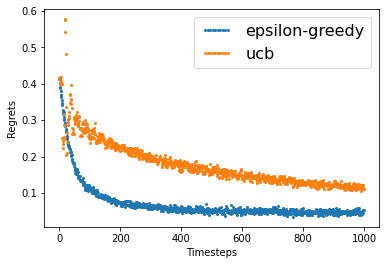

In [7]:
# Experiment 1
arm_count = 10 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

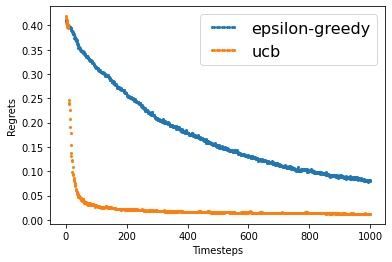

In [8]:
# Experiment 2 - change hyperparameters 
arm_count = 10 # number of arms in bandit
epsilon = 0.01
ucb_c = 0.2
stationary=True
experiment(arm_count)

In [9]:
def plot_data(y):
  """ y is a 1D vector """
  x = np.arange(y.size)
  _ = plt.plot(x, y, 'o')
  
def multi_plot_data(data, names):
  """ data, names are lists of vectors """
  x = np.arange(data[0].size)
  for i, y in enumerate(data):
    plt.plot(x, y, 'o', markersize=2, label=names[i])
    plt.xlabel("Timesteps")
    plt.ylabel("Regrets")
  plt.legend(loc='upper right', prop={'size': 16}, numpoints=10)
  plt.show()
  
def simulate(simulations, timesteps, arm_count, Algorithm):
  """ Simulates the algorithm over 'simulations' epochs """
  sum_regrets = np.zeros(timesteps)
  for e in range(simulations):
    bandit = Bandit(arm_count)
    algo = Algorithm(bandit)
    regrets = np.zeros(timesteps)
    for i in range(timesteps):
      action = algo.get_action()
      reward, regret = algo.get_reward_regret(action)
      regrets[i] = regret
    sum_regrets += regrets  
  mean_regrets = sum_regrets / simulations
  return mean_regrets

def experiment(arm_count, timesteps=1000, simulations=1000):
  """ 
  Standard setup across all experiments 
  Args:
    timesteps: (int) how many steps for the algo to learn the bandit
    simulations: (int) number of epochs
  """
  algos = [EpsilonGreedy, UCB, BernThompson, randomChoice]
  regrets = []
  names = []
  for algo in algos:
    regrets.append(simulate(simulations, timesteps, arm_count, algo))
    names.append(algo.name())
  multi_plot_data(regrets, names)

Then I add the Thompson Sampling model for comparison, and we note that that at first it outperforms Thompson. In the long run, although the UCB model has almost approached the Thompson Sampling model, the regret value has never been lower than it.

/var/folders/cl/hp9dr3bd4cndwdxx568xdw5m0000gn/T/ipykernel_81665/3769295903.py:20: RuntimeWarning: invalid value encountered in true_divide
  theta = self.Q / (self.Q + self.N)


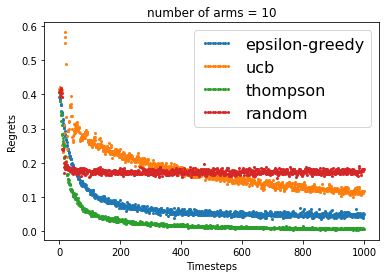

In [10]:
# Experiment 3
arm_count = 10 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
plt.title("number of arms = 10")
experiment(arm_count)

When all other condition factors are the same, we can observe that UCB model becomes very unstable and divergent after increasing the action space. It’s also because Bernoulli reward probabilities are close to each other. And random sampling is unstable at the beginning but tends to be stable later. Then, we can notice that the e-greedy result has hardly changed after adjusting the action space. Thompson's early performance is not as good as e-greedy model, but we can find that its regrets are gradually reduced and it’s worse than e-greedy at about timestep 300. In this case, I believe that Thompson's is optimal, because the Thompson algorithm is very stable in time in the long run.

/var/folders/cl/hp9dr3bd4cndwdxx568xdw5m0000gn/T/ipykernel_81665/3769295903.py:20: RuntimeWarning: invalid value encountered in true_divide
  theta = self.Q / (self.Q + self.N)


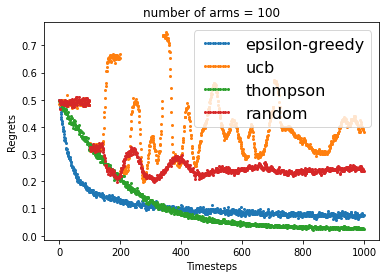

In [11]:
# Experiment 4
arm_count = 100 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
plt.title("number of arms = 100")
experiment(arm_count)

If the machine is the same, and the distribution of rewards sampled at each time step remains unchanged, this is called stationary. But if there is a deviation, it will be a non-stationary problem. Now we simulate this situation and set its environment to be non-stationary.

From the figure below, we can see that every 100 steps, regret will increase significantly. Moreover, UCB reacts much faster to bandit non-stationarity, much better than other models, and in fact continues to improve in regret over time, which is due to its high emphasis on exploration.

/var/folders/cl/hp9dr3bd4cndwdxx568xdw5m0000gn/T/ipykernel_81665/3769295903.py:20: RuntimeWarning: invalid value encountered in true_divide
  theta = self.Q / (self.Q + self.N)


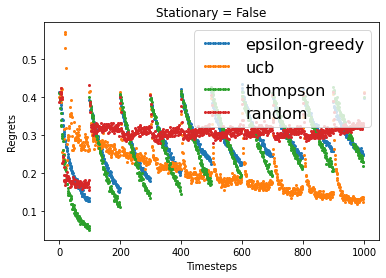

In [12]:
# Experiment 5 - Change its stationary to False
arm_count = 10 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=False
plt.title("Stationary = False")
experiment(arm_count)

In the graph below, increasing the timesteps to 10000 confirms that Thompson and UCB closely converge. We see that Thompson sampling greatly outperforms the other models. Also, UCB catch up to e-greedy at around timesteps 3000.

/var/folders/cl/hp9dr3bd4cndwdxx568xdw5m0000gn/T/ipykernel_81665/3769295903.py:20: RuntimeWarning: invalid value encountered in true_divide
  theta = self.Q / (self.Q + self.N)


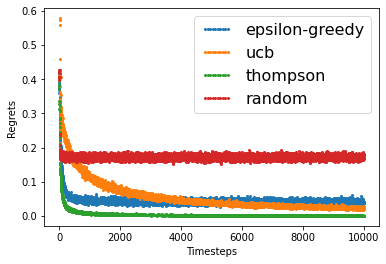

In [13]:
# Experiment 6
arm_count = 10 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count, timesteps=10000, simulations=1000)

###### Thompson Sampling with non-Beta distribution

In [210]:
class nonBetaAlgo():
  """
  The algos try to learn which Bandit arm is the best to maximize reward.
  
  It does this by modelling the distribution of the Bandit arms, 
  assuming the true probability of success of an arm is Gaussian distributed.
  """
  def __init__(self, bandit):
    """
    Args:
      bandit: the bandit class the algo is trying to model
    """
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.τ_0 = 0.0001  # the posterior precision
    self.μ_0 = 1       # the posterior mean  
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count)
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    """ Gaussian parameters return a value from the the posterior normal distribution """
    self.μ_0[arm] = ((self.τ_0[arm] * self.μ_0[arm]) + (self.N[arm] * self.Q[arm]))/(self.τ_0[arm] + self.N[arm])        
    self.τ_0[arm] += 1 
  
  
  @staticmethod
  def name():
    return 'nonbeta-greedy'


class GaussianThompson(nonBetaAlgo):
    
  def __init__(self, bandit):
    super().__init__(bandit)

  @staticmethod
  def name():
    return 'GaussianThompson'
  
  def get_action(self):
    """ Gaussian parameters update the mean and precision of the posterior """
    theta = (np.random.randn() / np.sqrt(self.τ_0)) + self.μ_0 
    return theta.argmax()


# References

Cited as:

# Copyright and Licensing

BSD 3-Clause License

Copyright (c) 2021, Shu-Ya Hsu
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this
  list of conditions and the following disclaimer.

* Redistributions in binary form must reproduce the above copyright notice,
  this list of conditions and the following disclaimer in the documentation
  and/or other materials provided with the distribution.

* Neither the name of the copyright holder nor the names of its
  contributors may be used to endorse or promote products derived from
  this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

In [ ]:
# Copyright (c) Hsu-Ya Hsu.
# Distributed under the terms of the 3-Clause BSD License.

You are free to use or adapt this notebook for any purpose you'd like. However, please respect the [Modified BSD License](https://jupyter.org/governance/projectlicense.html) that governs its use.